In [1]:
import numpy as np
from numpy.random import randint
from IPython.display import clear_output
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Conv2D
from keras import backend as K

Using TensorFlow backend.


In [3]:
import pyglet
from pyglet import app
from pyglet.window import Window, mouse, key
from pyglet import gl

In [390]:
# env
NOISE_MAG = .05

class Env(object):
    def __init__(self, r, c, vis_r):
        self.vis_r = vis_r #radius of snake vision
        self.r = r
        self.c = c
        
        vis2 = self.vis_r*2
        
        self.state = np.zeros((r, c, 3))
        self.state_padded = np.zeros((r+vis2, c+vis2, 3))
        self.define_model()
        self.reset()
        
    def reset(self, random_length=True):
        self.p = [randint(1, self.r-2), randint(1, self.c-2)]
        self.f = [randint(1, self.r-2), randint(1, self.c-2)]
        self.tail = []
        if random_length:
            self.length = np.random.randint(4, self.r*self.c-2*self.r-2*self.c)
        else:
            self.length = 4
        self.dir = 0 # direction
        self.step_count = 0
        self.end = False
        
        self.draw()
        
    def define_model(self):
        img_rows, img_cols = self.vis_r*2, self.vis_r*2
        
        input_shape = None
        if K.image_data_format() == 'channels_first':
            input_shape = (3, img_rows, img_cols)
        else:
            input_shape = (img_rows, img_cols, 3)
        
        self.model = Sequential()
        self.model.add(Conv2D(32, kernel_size=(3, 3),
                         activation='tanh',
                         input_shape=input_shape))
        self.model.add(Conv2D(32, (3, 3), activation='tanh'))
        #self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.20))
        self.model.add(Flatten())
        self.model.add(Dense(64, activation='tanh'))
        self.model.add(Dropout(0.20))
        self.model.add(Dense(4, activation='softmax'))
        
        self.model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(lr=1.0),
              metrics=['accuracy'])
        
    def randomize_model(self):
        # https://github.com/keras-team/keras/issues/341
        session = K.get_session()
        for layer in self.model.layers: 
            for v in layer.__dict__:
                v_arg = getattr(layer,v)
                if hasattr(v_arg,'initializer'):
                    initializer_method = getattr(v_arg, 'initializer')
                    initializer_method.run(session=session)
    
    def is_fail(self, p):
        if p[0] < 0 or p[0] > self.r-1 or p[1] < 0 or p[1] > self.c-1:
            return True
        return self.state[p[0], p[1], 1] == 1 # body
    
    def is_food(self, p):
        return p[0] == self.f[0] and p[1] == self.f[1]
    
    def draw(self):
        self.state[:] = 0
        
        #draw walls
        self.state[:,0,1] = 1
        self.state[:,self.c-1,1] = 1
        
        self.state[0,:,1] = 1
        self.state[self.r-1,:,1] = 1

        # draw tail
        for b in self.tail:
            self.state[b[0], b[1], 1] = 1
        
        # draw head and food
        self.state[self.p[0], self.p[1], 0] = 1
        self.state[self.f[0], self.f[1], 2] = 1
    
    def move(self, p, action):
        newp = [p[0], p[1]]
        if action == 0: #up
            newp[0] -= 1
        if action == 1: #down
            newp[0] += 1
        if action == 2: #left
            newp[1] -= 1
        if action == 3: #right
            newp[1] += 1
        return newp
    
    def step(self, explore=1.0, max_steps=150, noise=False):
        self.step_count += 1
        if self.step_count > max_steps: # max steps
            self.end = True
            return (None, None, 0)
        
        _state = None
        _action = None
        _reward = 1 # if you survive
        
        # get the state
        self.state_padded[self.vis_r:self.vis_r+self.r,
                          self.vis_r:self.vis_r+self.c] = self.state

        r, c = self.p[0]+self.vis_r, self.p[1]+self.vis_r # offset
        _state = self.state_padded[r-self.vis_r:r+self.vis_r, c-self.vis_r:c+self.vis_r].reshape(1, self.vis_r*2, self.vis_r*2, 3)
        _state = _state.copy()
        if noise:
            s = _state.shape
            _state += NOISE_MAG * np.random.randn(s[0], s[1], s[2], s[3])

        if np.sum(_state[0,:,:,2] == 0):
            # food offscreen, give some cue
            if self.p[0] < self.f[0]:
                _state[0,0,0,2] = 1
            else:
                _state[0,1,0,2] = 1

            if self.p[1] < self.f[1]:
                _state[0,0,0,2] = 1
            else:
                _state[0,0,1,2] = 1
        
        if np.random.random() < explore:
            p = self.p
            possible = []
            if self.state[p[0]-1, p[1], 1] == 0: # up
                possible += [0]
            if self.state[p[0]+1, p[1], 1] == 0: # down
                possible += [1]
            if self.state[p[0], p[1]-1, 1] == 0: # left
                possible += [2]
            if self.state[p[0], p[1]+1, 1] == 0: # right
                possible += [3]
                
            if len(possible) > 0:
                _action = np.random.choice(possible)
            else:
                _action = np.random.choice([0,1,2,3])
        else:
            # sample action
            dist = self.model.predict(_state)
            _action = np.argmax(dist)

        newp = self.move(self.p, _action)
            
        if self.is_food(newp):
            _reward = 2
            #grow and move food
            self.length += 1
            
            self.f = [randint(1, self.r-2), randint(1, self.c-2)]
            while self.state[self.f[0], self.f[1], 1] == 1 or self.state[self.f[0], self.f[1] , 0] == 1:
                self.f = [randint(1, self.r-2), randint(1, self.c-2)]

        elif self.is_fail(newp):
            self.end = True
            return (None, None, 0)
                
        # move to new position
        self.p = newp
            
        self.draw()
        
        # manage tail
        self.tail.insert(0, np.copy(self.p))
        if len(self.tail) > self.length:
            self.tail.pop()
        
        return (_state, _action, _reward) #sar

In [437]:
# create environment

env = Env(r=30, c=30, vis_r=7)

In [392]:
x_train, y_train = [], []

In [438]:
# gather some training data, then train it

i = 0
while len(x_train) < 200000:
    i += 1
    if (i+1) % 1000 == 0:
        print(len(x_train))
        
    session = []
    while not env.end:
        sar = env.step(explore=1, noise=False)
        
        session.append(sar)
        
        #if sar[2] == 1: # 1 survived, 2 food
        #    x_train.append(sar[0])
        #    action = np.zeros((1, 4))
        #    action[0, sar[1]] = 1
        #    y_train.append(action)
        
        if sar[2] == 2: # 1 survived, 2 food
            for s in session:
                x_train.append(s[0])
                action = np.zeros((1, 4))
                action[0, s[1]] = 1
                y_train.append(action)
            
    env.reset(random_length=True)

73108
76506
80472
83203
85746
88385
92063
94555
97059
100416
103750
106649
109520
112210
115691
118346
121303
125186
127684
130453
133103
135673
138793
141897
144038
146989
149867
152261
154996
157686
160954
164191
166319
169044
171666
174419
176931
179641
182094
185531
187776
190348
193485
196310
199587


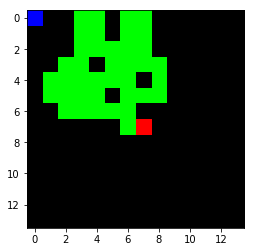

In [432]:
ri = np.random.choice(range(len(x_train)))
img = x_train[ri].reshape(env.vis_r*2, env.vis_r*2,3)
fig = plt.imshow(img)

In [439]:
_x_train = np.vstack(x_train)
_y_train = np.vstack(y_train)

s = _x_train.shape
_x_train += NOISE_MAG * np.random.randn(s[0], s[1], s[2], s[3])

env.model.fit(_x_train, _y_train, epochs=1, verbose=1)

Epoch 1/1
200042/200042 [==============================] - 70s - loss: 0.9801 - acc: 0.4622    


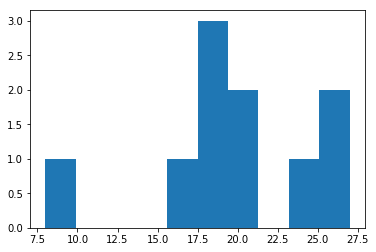

In [440]:
# run after training

rewards = []

env.reset(random_length=False)
for i in range(10):
    total_r = 0
    while not env.end:
        sar = env.step(explore=0, max_steps=500)
            
        if sar[2] == 2: # 1 survived, 2 food
            total_r += 1
    rewards.append(total_r)
    env.reset(random_length=False)
    
fig = plt.hist(rewards)

In [441]:
# visualize pyglet

bw, bh = 10, 10
win_width, win_height = bw*env.c, bh*env.r

# create window and run display it
win = Window(width=win_width, height=win_height)

def on_mouse_press(x, y, button, modifiers):
    env.reset(random_length=False)
    
win.push_handlers(on_mouse_press)

def draw_rect(x, y, w, h, color):
    pyglet.graphics.draw(6, gl.GL_TRIANGLES,
                    ('v2f', [x, y, 
                             x+w, y,
                             x+w, y+h, 
                             x, y, 
                             x, y+h, 
                             x+w, y+h]),
                    ('c4f', color * 6))
    

env.reset(random_length=False)

if 'loop' in globals():
    pyglet.clock.unschedule(loop)
    
def loop(e):
    global env
    env.step(explore=0, max_steps=10000000)
    if env.end:
        env.reset(random_length=False)

def on_draw():
    global env
    
    win.clear()
    for index, x in np.ndenumerate(env.state):
        if x != 0:
            # draw a rect
            c = [1,1,1,1]
            if index[2] == 1:
                c = [.5,.5,.5,1]
            elif index[2] == 2:
                c = [0,1,0,1]

            draw_rect(index[0]*bw, index[1]*bh, bw, bh, c)
win.on_draw = on_draw

pyglet.clock.schedule(loop)
    
pyglet.app.run()
    
win.close()

In [270]:
# visualize agent

for i in range(5):
    while not env.end:
        env.step(explore=0)
        clear_output(wait=True)
        plt.imshow(env.state, cmap=plt.cm.rainbow, vmin=-1, vmax=1)
        plt.show()
    env.reset()

KeyboardInterrupt: 